In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


CUDA_VISIBLE_DEVICES: 0 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [3]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

# Change Evidence Sentence in Unrelated Doc

,title,sents_len
6853,Nikita Bogoslovsky,3
3230,Palestinian National Theatre,3
4197,Anthony Steel (actor),3
4560,Michael Giacchino,3
2567,Rose Porteous,3
...,...,...
3668,Song of Freedom,16
3807,Manon Balletti,16
1019,Scotch and soda (magic trick),16
1785,Brazil–Pakistan relations,17


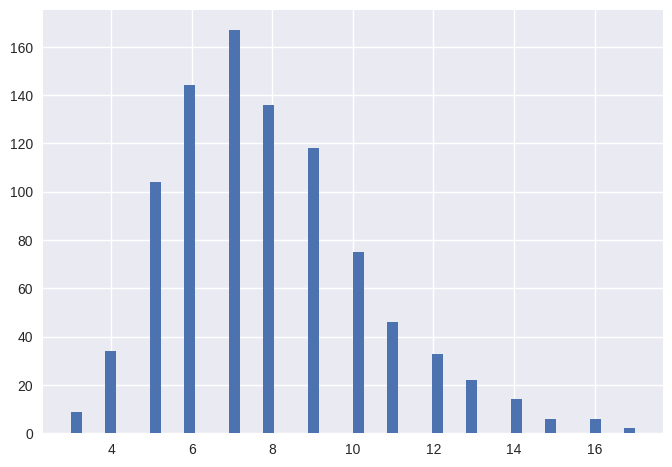

In [33]:
# df = df[df["gold_doc_len"] < 400]
df = df_raw.copy()
df = df.drop_duplicates(subset=["title"])
df = df[df["gold_doc_len"] < 400]
df["sents_len"] = df["sents"].apply(lambda x: len(x))
df = df.sort_values("sents_len").copy()
df[["title", "gold_doc_len", "sents_len"]]
df["sents_len"].hist(bins=50)

df[["title", "sents_len"]].sort_values("sents_len")

In [34]:
df = df_raw.copy()
UNRELATED_SENTS = df.loc[3807]["sents"]
df = df[df["title"] != df.loc[3807]["title"]]

def flatten(xss):
    return [x for xs in xss for x in xs]

df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
df = df[df["head_entity"].str.len() == 1]  # 1 Head
df = df[df["head_entity_in_evidence"].str.len() == 1]  # 1 Head in Evidence
df = df[df["head_entity_names"].str.len() == 1]  # All heads have the same name
# Filter Repeated Labels (Only 1 h->t)
# def not_repeated_label(label, labels):
#     repeat_count = 0
#     for l in labels:
#         if l['h'] == label['h'] and l['t'] == label['t']:
#             repeat_count += 1
#     return True if repeat_count == 1 else False
# df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
# df = df[df["repeated_label"]]
print(len(df))

# df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
# df["head_wo_tail_sentence"] = df.apply(lambda r: " ".join(flatten([s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]])), axis=1)

# df["sents_complete_wo_evidence"] = df.apply(lambda r: [s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]], axis=1)
sents_cols = []
for pos in range(15):
    def add_evidence(pos, r):
        sents = UNRELATED_SENTS.copy()
        sents.insert(pos, r["evidence_sents"][0])
        return sents
    df[f"sents_complete_w_evidence_{pos}"] = df.apply(lambda r: " ".join(flatten(add_evidence(pos, r))), axis=1)
    sents_cols.append(f"sents_complete_w_evidence_{pos}")
    
# df[f"sents_complete_w_evidence_{-1}"] = df.apply(lambda r: " ".join(flatten(UNRELATED_SENTS)), axis=1)
# sents_cols.append(f"sents_complete_w_evidence_{-1}")

# df["sents_complete_w_beginning"] = df.apply(lambda r: r["head_w_tail_sentence"] + " " + r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], ""), axis=1)

df = df.sample(250, random_state=0)
df.head(2)

1816


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,sents_complete_w_evidence_0,sents_complete_w_evidence_1,sents_complete_w_evidence_2,sents_complete_w_evidence_3,sents_complete_w_evidence_4,sents_complete_w_evidence_5,sents_complete_w_evidence_6,sents_complete_w_evidence_7,sents_complete_w_evidence_8,sents_complete_w_evidence_9,sents_complete_w_evidence_10,sents_complete_w_evidence_11,sents_complete_w_evidence_12,sents_complete_w_evidence_13,sents_complete_w_evidence_14
2320,test10350,"When was Klassics With A "" K "" published?",[Klassics with a &quot;K&quot;],"{'Klassics with a &quot;K&quot;': {'text': 'Klassics With A "" K "" , released in 1996 , was the only full - length album by Luscious Jackson members Vivian Trimble and Jill Cunniff . The only other Kostars release was a 7 "" single of the track Hey Cowbo...","{'len': 1000, 'max': 394.31365966796875, 'min': 385.3525390625, 'std': 1.1913469071069613, 'mean': 386.58818103027346, 'median': 386.2206726074219}",{'Klassics with a &quot;K&quot;': 394.31365966796875},"{'Klassics with a &quot;K&quot;': 394.31365966796875, 'Kostars': 393.54730224609375, 'Vlasis Gavriilidis': 392.445556640625, 'Frans Reinhold Kjellman': 391.8403625488281, 'Karolinska förbundet': 391.6370544433594, 'Asia Overland': 391.1734313964844, 'K...","{'Klassics with a &quot;K&quot;': {'text': 'Klassics With A "" K "" , released in 1996 , was the only full - length album by Luscious Jackson members Vivian Trimble and Jill Cunniff . The only other Kostars release was a 7 "" single of the track Hey Cowbo...",test10350,Klassics with a &quot;K&quot;,"[[{'sent_id': 0, 'type': 'MISC', 'pos': [0, 6], 'name': 'Klassics With A "" K ""', 'global_pos': [0, 0], 'index': '0_0'}], [{'pos': [9, 10], 'type': 'TIME', 'sent_id': 0, 'name': '1996', 'global_pos': [9, 9], 'index': '1_0'}], [{'sent_id': 2, 'type': 'OR...","[{'r': 'P463', 'h': 3, 't': 5, 'evidence': [0, 1]}, {'r': 'P463', 'h': 4, 't': 5, 'evidence': [0, 1]}, {'r': 'P463', 'h': 4, 't': 2, 'evidence': [0]}, {'r': 'P527', 'h': 5, 't': 3, 'evidence': [0, 1]}, {'r': 'P527', 'h': 5, 't': 4, 'evidence': [0, 1]},...","[[Klassics, With, A, "", K, "", ,, released, in, 1996, ,, was, the, only, full, -, length, album, by, Luscious, Jackson, members, Vivian, Trimble, and, Jill, Cunniff, .], [The, only, other, Kostars, release, was, a, 7, "", single, of, the, track, Hey, Cow...",test,"{'r': 'P577', 'h': 0, 't': 1, 'evidence': [0]}",6,"[{'sent_id': 0, 'type': 'MISC', 'pos': [0, 6], 'name': 'Klassics With A "" K ""', 'global_pos': [0, 0], 'index': '0_0'}]","[{'pos': [9, 10], 'type': 'TIME', 'sent_id': 0, 'name': '1996', 'global_pos': [9, 9], 'index': '1_0'}]","{Klassics With A "" K ""}",{1996},"Klassics With A "" K """,1996,{MISC},{TIME},[0],"[[Klassics, With, A, "", K, "", ,, released, in, 1996, ,, was, the, only, full, -, length, album, by, Luscious, Jackson, members, Vivian, Trimble, and, Jill, Cunniff, .]]","[{'sent_id': 0, 'type': 'MISC',

In [35]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

def flatten(xss):
    return [x for xs in xss for x in xs]
df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot2 = df.copy()


  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/15 [00:00<?, ?it/s]

facebook/dragon-roberta-query-encoder:   0%|          | 0/15 [00:00<?, ?it/s]

facebook/contriever-msmarco:   0%|          | 0/15 [00:00<?, ?it/s]

facebook/contriever:   0%|          | 0/15 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/15 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_2732710/3923951085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = embds_dot
/tmp/ipykernel_2732710/3923951085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = embds_dot
/tmp/ipykernel_2732710/3923951085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.co

  0%|          | 0/6 [00:00<?, ?it/s]

,Model,evidence_pos,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low,ttest_ci_high,mean_diff,std_diff,n
0,Contriever MSMARCO,1,facebook/contriever-msmarco_sents_complete_w_evidence_1_dot,facebook/contriever-msmarco_sents_complete_w_evidence_0_dot,-17.356064,9.153227e-45,1.650996,1.650996,-0.128443,0.117012,250
0,COCO-DR Base MSMARCO,1,OpenMatch/cocodr-base-msmarco_sents_complete_w_evidence_1_dot,OpenMatch/cocodr-base-msmarco_sents_complete_w_evidence_0_dot,-9.948723,7.514910e-20,1.650996,1.650996,-1.176610,1.869972,250
0,Dragon+,1,facebook/dragon-plus-query-encoder_sents_complete_w_evidence_1_dot,facebook/dragon-plus-query-encoder_sents_complete_w_evidence_0_dot,-9.006662,5.691121e-17,1.650996,1.650996,-0.431181,0.756948,250
0,Contriever,1,facebook/contriever_sents_complete_w_evidence_1_dot,facebook/contriever_sents_complete_w_evidence_0_dot,-14.115161,1.234111e-33,1.650996,1.650996,-0.058251,0.065251,250
0,Dragon RoBERTa,1,facebook/dragon-roberta-query-encoder_sents_complete_w_evidence_1_dot,facebook/dragon-roberta-query-encoder_sents_complete_w_evidence_0_dot,5.112391,6.345270e-07,1.650996,1.650996,0.285448,0.882822,250
...,...,...,...,...,...,...,...,...,...,...,...
13,Dragon+,14,facebook/dragon-plus-query-encoder_sents_complete_w_evidence_14_dot,facebook/dragon-plus-query-encoder_sents_complete_w_evidence_0_dot,-18.153610,1.735248e-47,1.650996,1.650996,-1.329893,1.158307,250
13,RetroMAE MSMARCO FT,14,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_14_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_0_dot,-10.020522,4.481549e-20,1.650996,1.650996,-1.016997,1.604720,250
13,COCO-DR Base MSMARCO,14,OpenMatch/cocodr-base-msmarco_sents_complete_w_evidence_14_dot,OpenMatch/cocodr-base-msmarco_sents_complete_w_evidence_0_dot,-12.447581,5.607988e-28,1.650996,1.650996,-1.496231,1.900569,250
13,Contriever,14,facebook/contriever_sents_complete_w_evidence_14_dot,facebook/contriever_sents_complete_w_evidence_0_dot,-6.638845,1.966146e-10,1.650996,1.650996,-0.034689,0.082617,250


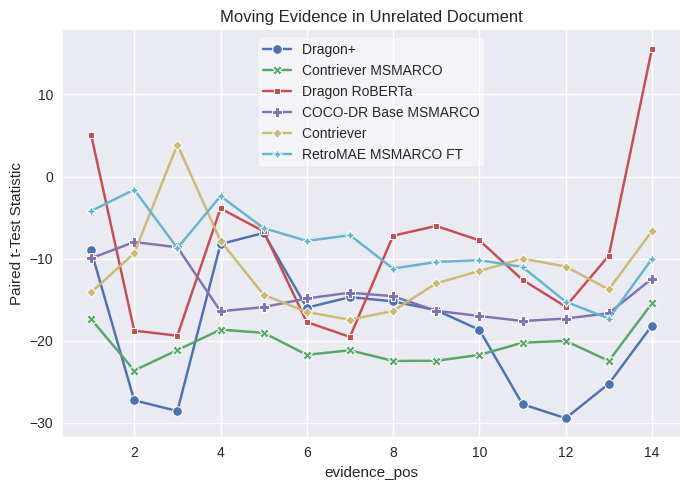

In [36]:
df = df_dot2.copy()

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_sents")[0] and query_model == col2.split("_sents")[0] and int(col2.split("_")[-2]) == 0 and col1 != col2:
                rdf.append({
                    "query_model": query_model,
                    "evidence_pos": int(col1.split("_")[-2]),
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                    "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "mean_diff": (df[col1] - df[col2]).mean(),
                    "std_diff": (df[col1] - df[col2]).std(),
                    "n": len(df),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)

# plt.figure(figsize=(6, 4))
# plt.title("Evidence in Initial vs. Final Sentence")
# ax = sns.barplot(data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn_r"), hue="Model")
# for container in ax.containers:
#     ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
# ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
# plt.tight_layout()

plt.figure(figsize=(7, 5))
sns.lineplot(results_df, x="evidence_pos", y="Paired t-Test Statistic", hue="Model", style="Model", markers=True, dashes=False)
plt.legend(frameon=True, facecolor='white', framealpha=0.5)
plt.title("Moving Evidence in Unrelated Document")
plt.tight_layout()

results_df.sort_values("evidence_pos")

  0%|          | 0/22500 [00:00<?, ?it/s]

,query_id,Model,sent_col,Evidence Sentence Position,dot,dot_0,dot_diff_0,Normalized Dot Product Similarity
0,test10350,Dragon+,sents_complete_w_evidence_0,1,384.878174,384.878174,0.000000,0.000000
1,test10350,Dragon RoBERTa,sents_complete_w_evidence_0,1,379.168274,379.168274,0.000000,0.000000
2,test10350,Contriever MSMARCO,sents_complete_w_evidence_0,1,1.202111,1.202111,0.000000,0.000000
3,test10350,Contriever,sents_complete_w_evidence_0,1,0.838227,0.838227,0.000000,0.000000
4,test10350,COCO-DR Base MSMARCO,sents_complete_w_evidence_0,1,208.015045,208.015045,0.000000,0.000000
...,...,...,...,...,...,...,...,...
22495,validation6456,Dragon RoBERTa,sents_complete_w_evidence_14,15,367.595825,366.667297,0.928528,0.928528
22496,validation6456,Contriever MSMARCO,sents_complete_w_evidence_14,15,0.719934,0.728330,-0.008396,-0.008396
22497,validation6456,Contriever,sents_complete_w_evidence_14,15,0.700109,0.706654,-0.006545,-0.006545
22498,validation6456,COCO-DR Base MSMARCO,sents_complete_w_evidence_14,15,201.926865,201.529266,0.397598,0.397598


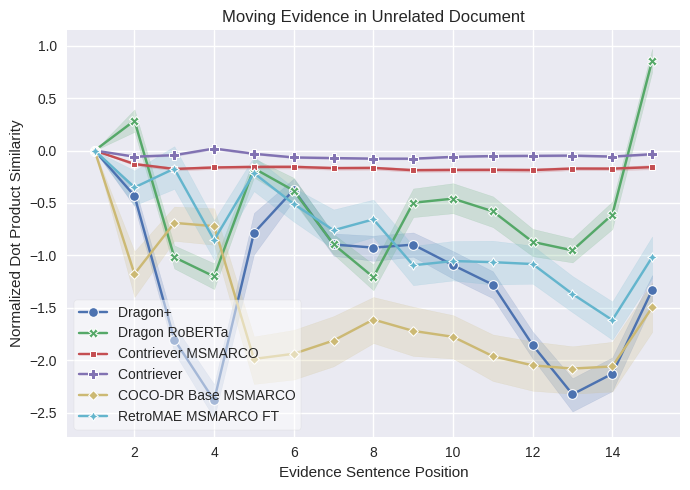

In [9]:
# OLD
df = df_dot2.copy()
df.head(3)
dfr = []
for row in df.to_dict(orient="records"):
    for sent_col in sents_cols:
        for query_model, context_model, POOLING in cfgs:
            new_col = f"{query_model}_{sent_col}_dot"
            dfr.append({
                "query_id": row["query_id"],
                "query_model": query_model,
                "sent_col": sent_col,
                "evidence_pos": int(sent_col.split("_")[-1]) + 1,
                "dot": row[new_col],
            })
dfr = pd.DataFrame(dfr)
dfr["dot_0"] = dfr.apply(lambda r: dfr[(dfr["query_model"] == r["query_model"]) & (dfr["query_id"] == r["query_id"]) & (dfr["evidence_pos"] == 1)]["dot"].iloc[0], axis=1)
dfr["dot_diff_0"] = dfr.apply(lambda r: r["dot"] - dfr[(dfr["query_model"] == r["query_model"]) & (dfr["query_id"] == r["query_id"]) & (dfr["evidence_pos"] == 1)]["dot"].iloc[0], axis=1)


model_mins = {}
model_maxs = {}
dot_n = []
for row in tqdm(dfr.to_dict(orient="records")):
    if row["query_model"] not in model_mins:
        model_mins[row["query_model"]] = dfr[dfr["query_model"] == row["query_model"]]["dot"].min()
        model_maxs[row["query_model"]] = dfr[dfr["query_model"] == row["query_model"]]["dot"].max()
    dot_n.append((row["dot"] - model_mins[row["query_model"]]) / (model_maxs[row["query_model"]] - model_mins[row["query_model"]]))
dfr["dot_normalized"] = dot_n
dfr["dot_normalized"] = dfr["dot_diff_0"]

model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
dfr["query_model"] = dfr["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])

dfr.rename(columns={"dot_normalized": "Normalized Dot Product Similarity", "evidence_pos": "Evidence Sentence Position", "query_model": "Model"}, inplace=True)

plt.figure(figsize=(7, 5))
sns.lineplot(dfr, x="Evidence Sentence Position", y="Normalized Dot Product Similarity", hue="Model", style="Model", markers=True, dashes=False)
plt.legend(frameon=True, facecolor='white', framealpha=0.5)
# plt.xticks([i for i in range(1, )])
plt.title("Moving Evidence in Unrelated Document")
plt.tight_layout()
plt.savefig("figs/position_evidence_dot.pdf")
dfr

# Change Evidence Sentence Pos [FINAL]

In [4]:
df = df_raw.copy()
def flatten(xss):
    return [x for xs in xss for x in xs]

df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
df = df[df["head_entity"].str.len() == 1]  # 1 Head
df = df[df["head_entity_in_evidence"].str.len() == 1]  # 1 Head in Evidence
df = df[df["head_entity_names"].str.len() == 1]  # All heads have the same name
# Filter Repeated Labels (Only 1 h->t)
def not_repeated_label(label, labels):
    repeat_count = 0
    for l in labels:
        if l['h'] == label['h'] and l['t'] == label['t']:
            repeat_count += 1
    return True if repeat_count == 1 else False
df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
df = df[df["repeated_label"]]

df["sents_len"] = df["sents"].apply(lambda x: len(x))
df = df[df["sents_len"] > 8]
df = df.groupby('title').tail(2)
# df = df.drop_duplicates(subset=["title"], keep="first")

print(len(df))

df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
# df["head_wo_tail_sentence"] = df.apply(lambda r: " ".join(flatten([s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]])), axis=1)

df["sents_complete_wo_evidence"] = df.apply(lambda r: [s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]], axis=1)
sents_cols = []
for pos in range(10):
    def add_evidence(pos, r):
        sents = r["sents_complete_wo_evidence"].copy()
        sents.insert(pos, r["evidence_sents"][0])
        return sents
    df[f"sents_complete_w_evidence_{pos}"] = df.apply(lambda r: " ".join(flatten(add_evidence(pos, r))), axis=1)
    sents_cols.append(f"sents_complete_w_evidence_{pos}")
    
# df[f"sents_complete_w_evidence_{-1}"] = df.apply(lambda r: " ".join(flatten(r["sents_complete_wo_evidence"])), axis=1)
# sents_cols.append(f"sents_complete_w_evidence_{-1}")

# df["sents_complete_w_beginning"] = df.apply(lambda r: r["head_w_tail_sentence"] + " " + r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], ""), axis=1)


df = df.sample(250, random_state=0)
print(df["title"].value_counts())
print(df["sents_len"].value_counts())
df.head(1)

275
title
Bombtrack                              2
Abbas Kiarostami                       2
Panlongcheng                           2
Between Five and Seven                 2
How to Save a Life (Grey's Anatomy)    2
                                      ..
Il regalo più grande                   1
The Christian Manifesto                1
Won-yong                               1
Gloria Estefan albums discography      1
Njangalude Veettile Athidhikal         1
Name: count, Length: 169, dtype: int64
sents_len
9     82
10    57
11    36
12    26
13    18
14    12
15     8
16     6
17     4
18     1
Name: count, dtype: int64


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,repeated_label,sents_len,sents_complete,sents_complete_wo_evidence,sents_complete_w_evidence_0,sents_complete_w_evidence_1,sents_complete_w_evidence_2,sents_complete_w_evidence_3,sents_complete_w_evidence_4,sents_complete_w_evidence_5,sents_complete_w_evidence_6,sents_complete_w_evidence_7,sents_complete_w_evidence_8,sents_complete_w_evidence_9
3325,test15241,What follows Last Dance?,[Entreat],"{'Entreat': {'text': 'Entreat is a live album by British alternative rock band The Cure , recorded at London 's Wembley Arena in July 1989 . It consists entirely of songs performed from the band 's 1989 record Disintegration ; while they were on their ...","{'len': 1000, 'max': 381.0211181640625, 'min': 371.1527404785156, 'std': 1.3811717466566742, 'mean': 372.57126904296877, 'median': 372.1581268310547}",{'Entreat': 374.3435363769531},"{'Just One Last Dance': 381.0211181640625, 'Bounce Streetdance Company': 379.9288330078125, 'Dance Dance Revolution Extreme': 379.147705078125, 'Dance with a Stranger': 378.0927429199219, 'Follow the Fleet': 377.92864990234375, 'Took the Last Train': 3...","{'Just One Last Dance': {'text': '"" Just One Last Dance "" is a song by German recording artist Sarah Connor , taken from her third studio album , Key to My Soul ( 2003 ) . The pop ballad was written and produced by Kay Denar and Rob Tyger . A reissue f...",test15241,Entreat,"[[{'name': 'Entreat', 'pos': [0, 1], 'sent_id': 4, 'type': 'MISC', 'global_pos': [74, 74], 'index': '0_0'}, {'name': 'Entreat', 'pos': [0, 1], 'sent_id': 0, 'type': 'MISC', 'global_pos': [0, 0], 'index': '0_1'}, {'name': 'Entreat', 'pos': [0, 1], 'sent...","[{'r': 'P577', 'h': 15, 't': 5, 'evidence': [5]}, {'r': 'P175', 'h': 15, 't': 2, 'evidence': [0, 5]}, {'r': 'P155', 'h': 18, 't': 17, 'evidence': [6]}, {'r': 'P175', 'h': 21, 't': 2, 'evidence': [0, 7]}, {'r': 'P17', 'h': 2, 't': 11, 'evidence': [0]}, ...","[[Entreat, is, a, live, album, by, British, alternative, rock, band, The, Cure, ,, recorded, at, London, 's, Wembley, Arena, in, July, 1989, .], [It, consists, entirely, of, songs, performed, from, the, band, 's, 1989, record, Disintegration, ;, while,...",test,"{'h': 17, 't': 18, 'r': 'P156', 'evidence': [6]}",31,"[{'pos': [6, 8], 'type': 'MISC', 'sent_id': 6, 'name': 'Last Dance', 'global_pos': [128, 128], 'index': '17_0'}]","[{'name': 'Prayers For Rain', 'pos': [11, 14], 'sent_id': 6, 'type': 'MISC', 'global_pos': [133, 133], 'index': '18_0'}]",{Last Dance},{Prayers For Rain},Last Dance,Prayers For Rain,{MISC},{MISC},[6],"[["", Fascination, Street, "", ,, "", Last, Dance, "", ,, "", Prayers, For, Rain, "", ,, and, "", Disintegration, "", were, also, included, as, B, -, sides, on, the, "", Pictures, of, You, "", CD, single, .]]","[{'pos': [6, 8], 'type': 'MISC', 'sent_id': 6, 'name': 'Last Dance', 'global_pos': [128, 128], 'index': '17_0'}]","[{'name': 'Prayers For Rain', 'pos': [11, 14

In [7]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    # ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

def flatten(xss):
    return [x for xs in xss for x in xs]
df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot2 = df.copy()

  0%|          | 0/5 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/10 [00:00<?, ?it/s]

facebook/dragon-roberta-query-encoder:   0%|          | 0/10 [00:00<?, ?it/s]

facebook/contriever-msmarco:   0%|          | 0/10 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/10 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,Model,Evidence Sentence Position,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low,ttest_ci_high,mean_diff,std_diff,n
0,RetroMAE MSMARCO FT,1,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_0_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_0_dot,0.000000,0.000000e+00,1.650996,1.650996,0.000000,0.000000,250
8,RetroMAE MSMARCO FT,9,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_8_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_0_dot,-3.916014,1.162988e-04,1.650996,1.650996,-0.392750,1.585778,250
4,RetroMAE MSMARCO FT,5,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_4_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_0_dot,-7.315604,3.508337e-12,1.650996,1.650996,-0.671220,1.450723,250
5,RetroMAE MSMARCO FT,6,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_5_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_0_dot,-5.557781,7.016342e-08,1.650996,1.650996,-0.525403,1.494725,250
3,RetroMAE MSMARCO FT,4,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_3_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_0_dot,-4.542964,8.651512e-06,1.650996,1.650996,-0.404082,1.406372,250


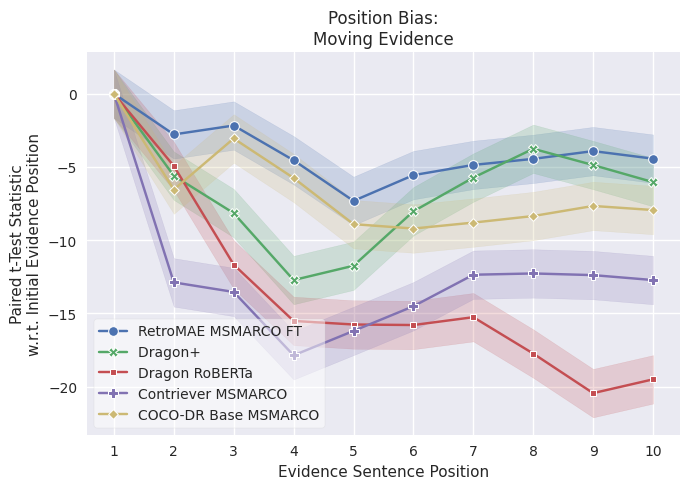

In [8]:
df = df_dot2.copy()

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_sents")[0] and query_model == col2.split("_sents")[0] and int(col2.split("_")[-2]) == 0:
                rdf.append({
                    "query_model": query_model,
                    "evidence_pos": int(col1.split("_")[-2]),
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                    "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "mean_diff": (df[col1] - df[col2]).mean(),
                    "std_diff": (df[col1] - df[col2]).std(),
                    "n": len(df),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)
results_df.fillna(0, inplace=True)
results_df["evidence_pos"] = results_df["evidence_pos"] + 1

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model", "evidence_pos": "Evidence Sentence Position"}, inplace=True)
results_df = results_df.sort_values("Model", ascending=False)

plt.figure(figsize=(7, 5))
def e(x):
    val = list(x)[0]
    return (val - 1.650996, val + 1.650996)

dfs = results_df.copy()
dfs = pd.concat([dfs, dfs])  # So sns calls errorbar!
ax = sns.lineplot(
    dfs, x="Evidence Sentence Position", y="Paired t-Test Statistic", hue="Model", style="Model", markers=True, dashes=False,
    errorbar=e
)
plt.xticks([i for i in range(1, 11)])
plt.legend(frameon=True, facecolor='white', framealpha=0.5)
plt.title("Position Bias:\nMoving Evidence")
plt.ylabel("Paired t-Test Statistic\nw.r.t. Initial Evidence Position")
plt.tight_layout()
plt.savefig("figs/moving_evidence_ttest.pdf")

results_df.head(5)

# Evidence First vs Last [FINAL]

In [4]:
df = df_raw.copy()
def flatten(xss):
    return [x for xs in xss for x in xs]

df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
df = df[df["head_entity"].str.len() == 1]  # 1 Head
df = df[df["head_entity_in_evidence"].str.len() == 1]  # 1 Head in Evidence
df = df[df["head_entity_names"].str.len() == 1]  # All heads have the same name
# Filter Repeated Labels (Only 1 h->t)
def not_repeated_label(label, labels):
    repeat_count = 0
    for l in labels:
        if l['h'] == label['h'] and l['t'] == label['t']:
            repeat_count += 1
    return True if repeat_count == 1 else False
df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
df = df[df["repeated_label"]]
print(len(df))

df["sents_len"] = df["sents"].apply(lambda x: len(x))
df = df[df["sents_len"] > 4]
df = df.groupby('title').tail(1)
print(len(df))

df = df.sample(250, random_state=0)
print(len(df))

df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
# df["head_wo_tail_sentence"] = df.apply(lambda r: " ".join(flatten([s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]])), axis=1)

df["sents_complete_wo_evidence"] = df.apply(lambda r: [s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]], axis=1)
sents_cols = []
def add_evidence(pos, r):
    sents = r["sents_complete_wo_evidence"].copy()
    if pos == -1:
        pos = len(sents)
    sents.insert(pos, r["evidence_sents"][0])
    return sents

df[f"sents_complete_w_evidence_first"] = df.apply(lambda r: " ".join(flatten(add_evidence(0, r))), axis=1)
df[f"sents_complete_w_evidence_last"] = df.apply(lambda r: " ".join(flatten(add_evidence(-1, r))), axis=1)
sents_cols.append(f"sents_complete_w_evidence_first")
sents_cols.append(f"sents_complete_w_evidence_last")

print(df["title"].value_counts())
print(df["sents_len"].value_counts())

save_cols = [
    "query", "gold_docs", "gold_docs_text", "scores_stats", "scores_gold", "predicted_docs_text_10", "id", "title", "vertexSet", 
    "labels", "sents", "split", "label", "label_idx", "head_entity", 
    "tail_entity", "head_entity_names", "tail_entity_names", 
    "head_entity_longest_name", "tail_entity_longest_name", 
    "head_entity_types", "tail_entity_types", "evidence_sent_ids", 
    "evidence_sents", "head_entity_in_evidence", "tail_entity_in_evidence", 
    "relation", "relation_name", "query_question", "duplicate_titles_len", 
    "duplicate_titles", "hit_rank", "gold_doc", "gold_doc_title", 
    "gold_doc_text", "gold_doc_score", "pred_doc", "pred_doc_title", 
    "pred_doc_text", "pred_doc_score", "gold_doc_len", "pred_doc_len",
] + sents_cols
df[save_cols].to_json("dataset/position_bias.jsonl", orient="records", lines=True)

df.head(1)

1247
476
250
title
University (album)               1
Word to the Mutha!               1
Raymond Hermantier               1
Financial District, Manhattan    1
David Bowie filmography          1
                                ..
Marcial Maciel                   1
Pavol Sedlák                     1
Cine-Allianz                     1
War of the Quadruple Alliance    1
Henri Guédon                     1
Name: count, Length: 250, dtype: int64
sents_len
6     51
7     42
5     33
8     31
9     30
10    21
11    15
12     7
13     7
15     4
14     3
16     2
17     2
18     1
20     1
Name: count, dtype: int64


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,repeated_label,sents_len,sents_complete,sents_complete_wo_evidence,sents_complete_w_evidence_first,sents_complete_w_evidence_last
3524,test16129,When was Purgatory / Paradise published?,[University (album)],"{'University (album)': {'text': 'University is the 1995 album by the American alternative rock band Throwing Muses , released on Sire Records and Reprise Records in the USA , and on 4AD elsewhere . It features the single "" Bright Yellow Gun "" , the ban...","{'len': 1000, 'max': 391.29107666015625, 'min': 380.3038330078125, 'std': 1.200096670123342, 'mean': 381.57035665893557, 'median': 381.20945739746094}",{'University (album)': 385.259521484375},"{'Purgatorio': 391.29107666015625, 'The Dream of Gerontius (poem)': 389.28851318359375, 'Paradise Lost': 388.1291198730469, 'The Final Circle of Paradise': 387.7815856933594, 'Days of Purgatory': 387.4746398925781, 'The Marriage of Heaven and Hell': 38...","{'Purgatorio': {'text': 'Purgatorio (; Italian for "" Purgatory "" ) is the second part of Dante 's Divine Comedy , following the Inferno , and preceding the Paradiso . The poem was written in the early 14th century . It is an allegory telling of the cli...",test16129,University (album),"[[{'name': 'University', 'pos': [0, 1], 'sent_id': 0, 'type': 'MISC', 'global_pos': [0, 0], 'index': '0_0'}], [{'type': 'TIME', 'pos': [3, 4], 'name': '1995', 'sent_id': 0, 'global_pos': [3, 3], 'index': '1_0'}, {'type': 'TIME', 'pos': [8, 9], 'name': ...","[{'r': 'P495', 'h': 7, 't': 2, 'evidence': [0, 1]}, {'r': 'P264', 'h': 7, 't': 4, 'evidence': [0, 1]}, {'r': 'P264', 'h': 7, 't': 5, 'evidence': [0, 1]}, {'r': 'P264', 'h': 7, 't': 6, 'evidence': [0, 1]}, {'r': 'P175', 'h': 7, 't': 3, 'evidence': [0, 1...","[[University, is, the, 1995, album, by, the, American, alternative, rock, band, Throwing, Muses, ,, released, on, Sire, Records, and, Reprise, Records, in, the, USA, ,, and, on, 4AD, elsewhere, .], [It, features, the, single, "", Bright, Yellow, Gun, "",...",test,"{'r': 'P577', 'h': 19, 't': 18, 'evidence': [7]}",19,"[{'type': 'MISC', 'pos': [29, 32], 'name': 'Purgatory / Paradise', 'sent_id': 7, 'global_pos': [185, 185], 'index': '19_0'}]","[{'type': 'TIME', 'pos': [27, 28], 'name': '2013', 'sent_id': 7, 'global_pos': [183, 183], 'index': '18_0'}]",{Purgatory / Paradise},{2013},Purgatory / Paradise,2013,{MISC},{TIME},[7],"[[The, band, has, continued, sporadically, ever, since, ,, releasing, two, more, albums, on, the, independent, 4AD, ,, one, in, 1996, and, one, in, 2003, ,, before, releasing, 2013, 's, Purgatory, /, Paradise, on, their, own, label, .]]","[{'type': 'MISC', 'pos': [29, 32], 'name': 'Purgatory / Paradise', 'sent_id': 7, 'global_pos': [185, 185], 'index': '19_0'}]","[{'type': 'TIME', 'pos': [27, 28], 'name': '2013', 'sent_id': 7, 'global_pos': [183, 183], 'index': '18_0'}]",P577,publication date,When was Purgatory / Paradise published?

In [5]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

def flatten(xss):
    return [x for xs in xss for x in xs]
df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low,ttest_ci_high,mean_diff,std_diff,n
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_first_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_last_dot,3.859581,1.447797e-04,1.650996,1.650996,0.499989,2.048283,250
0,Contriever,facebook/contriever_sents_complete_w_evidence_first_dot,facebook/contriever_sents_complete_w_evidence_last_dot,6.055156,5.137977e-09,1.650996,1.650996,0.026721,0.069775,250
0,Dragon+,facebook/dragon-plus-query-encoder_sents_complete_w_evidence_first_dot,facebook/dragon-plus-query-encoder_sents_complete_w_evidence_last_dot,6.350041,1.013572e-09,1.650996,1.650996,0.622528,1.550074,250
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_sents_complete_w_evidence_first_dot,OpenMatch/cocodr-base-msmarco_sents_complete_w_evidence_last_dot,8.855481,1.602171e-16,1.650996,1.650996,0.907946,1.621130,250
0,Contriever MSMARCO,facebook/contriever-msmarco_sents_complete_w_evidence_first_dot,facebook/contriever-msmarco_sents_complete_w_evidence_last_dot,12.044973,1.241210e-26,1.650996,1.650996,0.079294,0.104089,250
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_sents_complete_w_evidence_first_dot,facebook/dragon-roberta-query-encoder_sents_complete_w_evidence_last_dot,18.834524,8.486578e-50,1.650996,1.650996,1.602245,1.345068,250


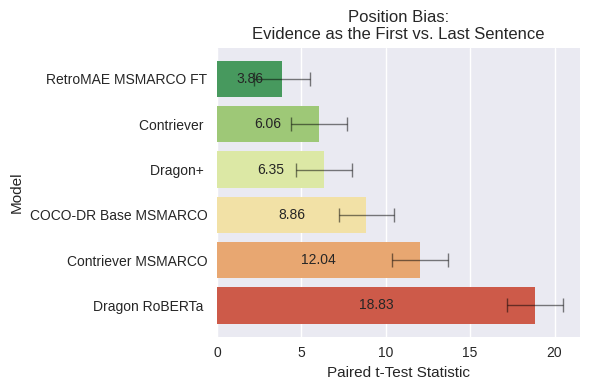

In [6]:
df = df_dot.copy()

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_sents")[0] and query_model == col2.split("_sents")[0] and col1 != col2 and "first" in col1:
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                    "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "mean_diff": (df[col1] - df[col2]).mean(),
                    "std_diff": (df[col1] - df[col2]).std(),
                    "n": len(df),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)
plt.figure(figsize=(6, 4))
plt.title("Position Bias:\nEvidence as the First vs. Last Sentence")
ax = sns.barplot(data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn_r"), hue="Model")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
results_df.to_json("results/position_df.json", orient="records")
# ax.bar_label(ax.containers[0], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')
# ax.bar_label(ax.containers[1], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')

plt.tight_layout()
plt.savefig("figs/initial_final_evidence_ttest.pdf")
results_df

In [40]:
# Find Example
pd.set_option('display.max_colwidth', 1800)
df = df_dot.copy()
df["diff"] = df["facebook/dragon-plus-query-encoder_sents_complete_w_evidence_first_dot"] - df["facebook/dragon-plus-query-encoder_sents_complete_w_evidence_last_dot"]
df["evidence_text"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
df["evidence_len"] = df["evidence_text"].apply(lambda x: len(x.split()))
print(df["evidence_len"].describe())
df = df[df["evidence_len"] < 20]
df[sents_cols + ["title", "query", "evidence_text", "gold_doc_len", "diff"]].sort_values("diff", ascending=False)

count    250.000000
mean      32.104000
std       14.179188
min        8.000000
25%       22.000000
50%       30.000000
75%       38.000000
max       89.000000
Name: evidence_len, dtype: float64


,sents_complete_w_evidence_first,sents_complete_w_evidence_last,title,query,evidence_text,gold_doc_len,diff
2367,"Wolfgang Thüne ( born 8 October 1949 ) is a German former gymnast . He competed at the 1972 Summer Olympics in all artistic gymnastics events and won a bronze medal with the East German team . Individually his best achievement was seventh place in the horizontal bar . He won two more bronze team medals at the world championships in 1970 and 1974 as well as individual silver in the horizontal bar in 1974 . At the 1975 European championships in Bern , he fled to West Germany with the help of his rival Eberhard Gienger . In 1977 he won the national all - round title in West Germany competing for TuS 04 Leverkusen . After retirement he worked as a gymnastics coach at the same club .","He competed at the 1972 Summer Olympics in all artistic gymnastics events and won a bronze medal with the East German team . Individually his best achievement was seventh place in the horizontal bar . He won two more bronze team medals at the world championships in 1970 and 1974 as well as individual silver in the horizontal bar in 1974 . At the 1975 European championships in Bern , he fled to West Germany with the help of his rival Eberhard Gienger . In 1977 he won the national all - round title in West Germany competing for TuS 04 Leverkusen . After retirement he worked as a gymnastics coach at the same club . Wolfgang Thüne ( born 8 October 1949 ) is a German former gymnast .",Wolfgang Thüne,When was Wolfgang Thüne born?,Wolfgang Thüne ( born 8 October 1949 ) is a German former gymnast .,132,7.190887
155,"Elsa Wiezell ( 1926 – 2014 ) , poet , teacher , artist This is a list of women writers who were born in Paraguay or whose writings are closely associated with that country . Dora Acuña ( 1903 – 1987 ) , poet , journalist , radio presenter Gladys Carmagnola ( born 1939 ) , acclaimed poet , works for adults and children Raquel Chaves ( born 1939 ) , poet , journalist , educator Susy Delgado ( born 1949 ) , poet , writes in Spanish and Guarani Renée Ferrer de Arréllaga ( born 1944 ) , poet , novelist Josefina Pla ( 1903 – 1999 ) , Spanish - born Paraguayan poet , playwright , critic , journalist Mercedes Sandoval de Hempel ( 1919 – 2005 ) , lawyer , feminist , legal writings Carmen Soler ( 1924 – 1985 ) , poet , educator , moved to Argentina Faith Wilding ( born 1943 ) , Paraguayan - American feminist artist , non - fiction writer , educator","This is a list of women writers who were born in Paraguay or whose writings are closely associated with that country . Dora Acuña ( 1903 – 1987 ) , poet , journalist , radio presenter Gladys Carmagnola ( born 1939 ) , acclaimed poet , works for adults and children Raquel Chaves ( born 1939 ) , poet , journalist , educator Susy Delgado ( born 1949 ) , poet , writes in Spanish and Guarani Renée Ferrer de Arréllaga ( born 1944 ) , poet , novelist Josefina Pla ( 1903 – 1999 ) , Spanish - born Paraguayan poet , playwright , critic , journalist Mercedes Sandoval de Hempel ( 1919 – 2005 ) , lawyer , feminist , legal writings Carmen Soler ( 1924 – 1985 ) , poet , educator , moved to Argentina Faith Wilding ( born 1943 ) , Paraguayan - American feminist artist , non - fiction writer , educator Elsa Wiezell ( 1926 – 2014 ) , poet , teacher , artist",List of Paraguayan women writers,When was Elsa Wiezell born?,"Elsa Wiezell ( 1926 – 2014 ) , poet , teacher , artist",176,4.042633
2922,"Louis Moreau Gottschalk , New Orleans , United States ( 1829 – 1869 ) This is a list of composers of Caribbean descent . The Caribbean is a region consisting of the Caribbean Sea , its islands ( most of which are enclosed by the sea ) , and the surrounding coasts . The region is located southeast of the Gulf of Mexico and North America , east of Central America , and to the north of South America . The Caribbean has produced many notable composers , who have contributed in a variety of ways to the history of Western classical mu

# Without Changing Data

In [ ]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

df = df_raw.copy()
def flatten(xss):
    return [x for xs in xss for x in xs]
df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))

plot_col_dots = []
for query_model, context_model, POOLING in cfgs:
    dpr = YourCustomDEModel(query_model, context_model, POOLING)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    
    embds = dpr.encode_corpus(to_doc_format(df['sents_complete'].to_list()))
    query_embds = dpr.encode_queries(df['query'].to_list())
    embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
    new_col = f"{query_model}_dot"
    print(new_col)
    df[new_col] = embds_dot
    plot_col_dots.append(new_col)
    
df_dot = df.copy()

In [ ]:
def analyze_pos(dfc):
    df = dfc.copy()
    df["cumsum_sent_len"] = df["sents"].apply(lambda x: np.cumsum([0] + [len(s) for s in x]))
    df["heads_pos"] = df.apply(lambda r: [h["pos"][0] + r["cumsum_sent_len"][h["sent_id"]] for h in r["head_entity"]], axis=1)
    df["first_head_pos"] = df["heads_pos"].apply(lambda x: min(x))
    # df = df[df["first_head_pos"] < 50]
    df["first_head_pos_relative"] = 100 * df["first_head_pos"] / df["sents"].apply(lambda x: len(flatten(x)))
    df["first_head_pos_relative"] = df["first_head_pos_relative"].astype(int)
    # df["first_head_pos_relative"] = pd.cut(df["first_head_pos_relative"], bins=[-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90])
    df["first_head_pos_relative"] = pd.cut(df["first_head_pos_relative"], bins=[-1, 5, 10, 20, 30, 100], labels=[0, 5, 10, 20, 30,])
    
    for col in plot_col_dots:
        df[col+"_normalized"] = (df[col] - df[col].min()) / (df[col].max() + df[col].min())
        sns.lineplot(data=df, x="first_head_pos_relative", y=col+"_normalized", label=col+"_normalized", marker="o")
        # plt.show()
    return df.head(1)

analyze_pos(df_dot)

In [ ]:
def analyze_pos(dfc):
    df = dfc.copy()
    df["evidence_sent_id"] = df["evidence_sent_ids"].apply(lambda x: x[0])
    df["evidence_sent_id_relative"] = 100 * df["evidence_sent_id"] / df["sents"].apply(lambda x: len(x))
    # df["first_head_pos_relative"] = pd.cut(df["first_head_pos_relative"], bins=[-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90])
    df["evidence_sent_id_relative"] = pd.cut(df["evidence_sent_id_relative"], bins=[-1, 5, 10, 20, 30, 100], labels=[0, 5, 10, 20, 30,])
    
    for col in plot_col_dots:
        df[col+"_normalized"] = (df[col] - df[col].min()) / (df[col].max() + df[col].min())
        sns.lineplot(data=df, x="evidence_sent_id_relative", y=col+"_normalized", label=col+"_normalized", marker="o")
        # plt.show()
    return df.head(1)

analyze_pos(df_dot)

In [ ]:
df